# Continuous Glucose Monitoring

This notebook serves as an introduction to working with the CGM data in mHealth format. It will open one file and make a few plots.

Information on this format may be found at https://github.com/openmhealth 


File organization is expected to follow this pattern:

pilot_data_root           
&emsp;wearable_blood_glucose    
&emsp;&emsp;manifest.tsv    
&emsp;&emsp;continuous_glucose_monitoring    
&emsp;&emsp;&emsp;dexcom_g6    
&emsp;&emsp;&emsp;&emsp;0001    
&emsp;&emsp;&emsp;&emsp;&emsp;0001_DEX.json     
&emsp;&emsp;&emsp;&emsp;0002    
&emsp;&emsp;&emsp;&emsp;&emsp;0002_DEX.json   
&emsp;&emsp;&emsp;&emsp;... etc.

In [181]:
import json

import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt  # to make plots
import matplotlib.dates as mdates  # to use ConciseDateFormatter

In [182]:
print(f'pd version: {pd.__version__}')  # pd 2.1.4 was used for dev

pd version: 2.2.2


## custom path -- change to match your file structure

In [183]:
pilot_data_root = "Dataset/dataset/"  # change this to your own path

# Read the manifest

In [184]:
manifest_path = pilot_data_root + "wearable_blood_glucose/manifest.tsv"
print(manifest_path)

Dataset/dataset/wearable_blood_glucose/manifest.tsv


In [185]:
dfm = pd.read_csv(manifest_path, sep='\t')
print(dfm.columns)

Index(['participant_id', 'glucose_filepath', 'glucose_level_record_count',
       'average_glucose_level_mg_dl', 'glucose_sensor_sampling_duration_days',
       'glucose_sensor_id', 'manufacturer', 'manufacturer_model_name'],
      dtype='object')


In [186]:
dfm['participant_id'].nunique()  # number of unique participants

1049

In [187]:
dfm.head()

,participant_id,glucose_filepath,glucose_level_record_count,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days,glucose_sensor_id,manufacturer,manufacturer_model_name
0,1001,wearable_blood_glucose/continuous_glucose_moni...,2856,123.304272,11,PG15103578,Dexcom,G6
1,1002,wearable_blood_glucose/continuous_glucose_moni...,2844,116.446203,11,PG15103578,Dexcom,G6
2,1003,wearable_blood_glucose/continuous_glucose_moni...,2856,208.075280,11,PG15103578,Dexcom,G6
3,1004,wearable_blood_glucose/continuous_glucose_moni...,2856,188.661064,11,PG15103578,Dexcom,G6
4,1005,wearable_blood_glucose/continuous_glucose_moni...,2856,262.778361,11,PG15103578,Dexcom,G6


In [188]:
key_columns = ['participant_id', 'average_glucose_level_mg_dl',
               'glucose_sensor_sampling_duration_days']  # optionally view only a few columns

dfm[key_columns].head(2)

,participant_id,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days
0,1001,123.304272,11
1,1002,116.446203,11


# Select a set of data to explore

In [189]:
import constants
pid = constants.pid  # select a participant ID

pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
print(f'{pid} full path: {pid_cgm}')

1322 full path: wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1322/1322_DEX.json


In [190]:
cgm_path = pilot_data_root + pid_cgm
print(cgm_path)

Dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1322/1322_DEX.json


## read and explore the data

### open the mHealth formatted data

In [191]:
# read the mHealth formatted data as json
with open(cgm_path,'r') as f:
    data = json.load(f)
print(data.keys())

dict_keys(['header', 'body'])


In [192]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [193]:
cgm_header = flatten_json(data['header'])
print(cgm_header)

{'uuid': 'AIREADI-1322', 'creation_date_time': '2024-10-01T21:09:13Z', 'patient_id': 'AIREADI-1322', 'schema_id_namespace': 'omh', 'schema_id_name': 'blood-glucose', 'schema_id_version': 3.0, 'modality': 'sensed', 'acquistion_rate_number_of_times': 1, 'acquistion_rate_time_window_value': 5, 'acquistion_rate_time_window_unit': 'min', 'external_datasheets_datasheet_type': 'source_device', 'external_datasheets_datasheet_reference': 'iri-of-cgm-device', 'timezone': 'pst'}


In [194]:
# CGM observations are in a list of nested dicts; flatten these 
list_of_body_dicts = list()
for observation in data['body']['cgm']:
    flat_obs = flatten_json(observation)
    list_of_body_dicts.append(flat_obs)

print(f'Number of observations: {len(list_of_body_dicts)}')

Number of observations: 2855


### convert to pandas data frame

In [195]:
df = pd.DataFrame.from_records(list_of_body_dicts)
print(df.shape)

(2855, 9)


In [196]:
print(f'CGM columns: {df.columns}')

CGM columns: Index(['effective_time_frame_time_interval_start_date_time',
       'effective_time_frame_time_interval_end_date_time', 'event_type',
       'source_device_id', 'blood_glucose_unit', 'blood_glucose_value',
       'transmitter_time_unit', 'transmitter_time_value', 'transmitter_id'],
      dtype='object')


In [197]:
df.rename(columns={'effective_time_frame_time_interval_start_date_time':'start_time',
                   'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)

In [198]:
def convert_time_string_to_datetime(t_str):
    '''Converts time string to datetime format. Does not convert to local time.
    Args:
        t_str (str): UTC time string such as 2023-08-01T20:39:33Z 
    Returns: datetime object
    '''
    datetime_object = datetime.strptime(t_str, '%Y-%m-%dT%H:%M:%SZ')  # 4 digit Year
    return datetime_object

In [199]:
df['start_dtime'] = df.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)

In [200]:
df.info()  # note that blood_glucose_value may be object; int is expected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855 entries, 0 to 2854
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   start_time              2855 non-null   object        
 1   end_time                2855 non-null   object        
 2   event_type              2855 non-null   object        
 3   source_device_id        2855 non-null   object        
 4   blood_glucose_unit      2855 non-null   object        
 5   blood_glucose_value     2855 non-null   int64         
 6   transmitter_time_unit   2855 non-null   object        
 7   transmitter_time_value  2855 non-null   int64         
 8   transmitter_id          2855 non-null   object        
 9   start_dtime             2855 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 223.2+ KB


In [201]:
df.head()

,start_time,end_time,event_type,source_device_id,blood_glucose_unit,blood_glucose_value,transmitter_time_unit,transmitter_time_value,transmitter_id,start_dtime
0,2024-06-12T21:42:58Z,2024-06-12T21:42:58Z,EGV,PG15103578,mg/dL,101,long integer,7573,378PMM,2024-06-12 21:42:58
1,2024-06-12T21:47:58Z,2024-06-12T21:47:58Z,EGV,PG15103578,mg/dL,90,long integer,7873,378PMM,2024-06-12 21:47:58
2,2024-06-12T21:52:58Z,2024-06-12T21:52:58Z,EGV,PG15103578,mg/dL,102,long integer,8173,378PMM,2024-06-12 21:52:58
3,2024-06-12T21:57:58Z,2024-06-12T21:57:58Z,EGV,PG15103578,mg/dL,113,long integer,8473,378PMM,2024-06-12 21:57:58
4,2024-06-12T22:02:58Z,2024-06-12T22:02:58Z,EGV,PG15103578,mg/dL,117,long integer,8773,378PMM,2024-06-12 22:02:58


In [202]:
mask_bg_int_only = ~df['blood_glucose_value'].isin(['Low','High'])
bg_min = df[mask_bg_int_only]["blood_glucose_value"].min()
bg_max = df[mask_bg_int_only]["blood_glucose_value"].max()
print(f'Lowest blood_glucose_value: {bg_min}')
print(f'Highest blood_glucose_value: {bg_max}')

Lowest blood_glucose_value: 90
Highest blood_glucose_value: 333


## GET START AND END TIME OF EACH PATIENT

In [203]:
def get_start_end_time(sample_id):
    pid = sample_id

    pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
    cgm_path = pilot_data_root + pid_cgm

    with open(cgm_path, 'r') as f:
        data = json.load(f)

    cgm_header = flatten_json(data['header'])

    cgm_data = data['body']['cgm']

    if not cgm_data:
        return None, None  # Handle empty case

    first_obs = flatten_json(cgm_data[0])
    last_obs = flatten_json(cgm_data[-1])

    df = pd.DataFrame.from_records([first_obs, last_obs])
    df.rename(columns={'effective_time_frame_time_interval_start_date_time':'start_time', 'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)
    df['start_dtime'] = df.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)

    
    return df['start_dtime'].min(), df['start_dtime'].max()

## plot blood glucose values

### handle non-numeric blood glucose values

Most values are integers, but some may be either "High" or "Low".     
The sensor reports    
 - <  40 "Low"     
 - \> 400 "High"
   
The terms "Low" and "High" can be replaced with these values, or more extreme values could be used (0, 500) for visualization purposes.

In [204]:
# df['blood_glucose_value'].value_counts()  # peek at the value distribution
low_value = 40  # select a value to use for low
high_value = 400  # select a value to use for high

if (0):
    df.replace({"Low": low_value, "High": high_value}, inplace=True)  # notebook dev used pd 2.1.4
else:  # to avoid the FutureWarning regarding Downcasting behavior in 'replace'

    def replace_alt(val, low_value, high_value):
        if val == "Low":
            return low_value
        elif val == "High":
            return high_value
        else:
            return val

    df['blood_glucose_value'] = df.apply(lambda x: replace_alt(x['blood_glucose_value'],
                                                               low_value, high_value), axis=1)

In [205]:
# df.info()  # optional view of the Dtype for each column of data; blood glucose should be int

In [206]:
yaxis_adjusts_to_data = True

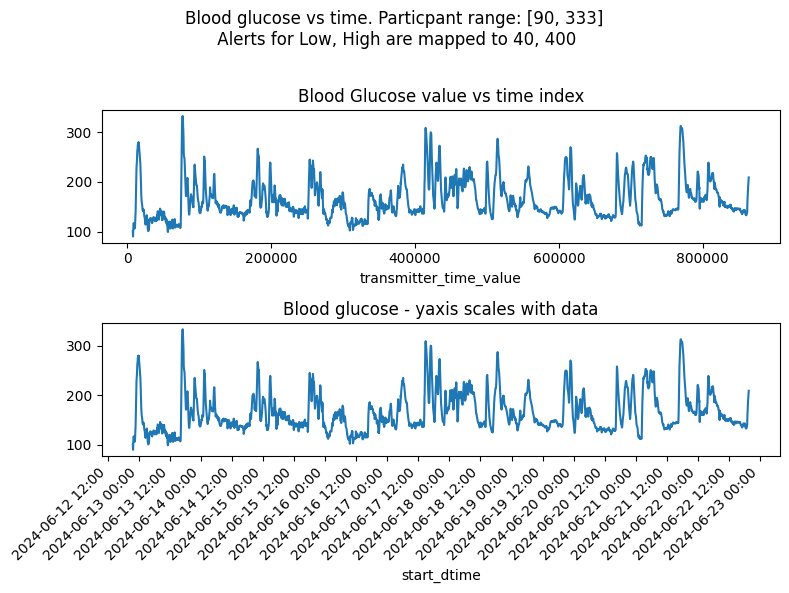

In [207]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f'Blood glucose vs time. Particpant range: [{bg_min}, {bg_max}]\n Alerts for Low, High are mapped to {low_value}, {high_value}\n')

df.plot.line(x='transmitter_time_value', y='blood_glucose_value', ax=ax[0], legend=False)
ax[0].set_title("Blood Glucose value vs time index")

df.plot.line(x='start_dtime', y='blood_glucose_value', ax=ax[1], legend=False)
ax[1].set_title("Blood Glucose value vs. timestamp")
if (yaxis_adjusts_to_data):
    ax[1].set_title('Blood glucose - yaxis scales with data')
else:
    ax[1].set_title('Blood glucose - yaxis [0, 505]')
    ax[1].set_ylim(0, 505)
ax[1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 12]))  # each day at noon
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=True,       # set ticks along the bottom edge on
#     top=False,         # set ticks along the top edge off
#     labelbottom=True)  # set labels along the bottom edge on

# plt.xlabel('timestamp')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [208]:
#Read the participants manifest
participants_manifest_path = pilot_data_root + 'participants.tsv'
print(participants_manifest_path)

Dataset/dataset/participants.tsv


In [209]:
df_participant = pd.read_csv(participants_manifest_path, sep='\t')
print(df_participant.nunique())  # number of unique participants
df_participant.head()

participant_id               1067
clinical_site                   3
study_group                     4
age                            48
study_visit_date              245
recommended_split               3
cardiac_ecg                     2
clinical_data                   1
environment                     2
retinal_flio                    2
retinal_oct                     2
retinal_octa                    2
retinal_photography             2
wearable_activity_monitor       2
wearable_blood_glucose          2
dtype: int64


,participant_id,clinical_site,study_group,age,study_visit_date,recommended_split,cardiac_ecg,clinical_data,environment,retinal_flio,retinal_oct,retinal_octa,retinal_photography,wearable_activity_monitor,wearable_blood_glucose
0,1001,UW,pre_diabetes_lifestyle_controlled,69,2023-07-27,train,True,True,True,True,True,True,True,False,True
1,1002,UW,healthy,69,2023-08-01,train,True,True,True,True,True,True,True,False,True
2,1003,UW,oral_medication_and_or_non_insulin_injectable_...,82,2023-08-02,train,True,True,True,True,True,True,True,False,True
3,1004,UW,oral_medication_and_or_non_insulin_injectable_...,61,2023-08-08,val,True,True,True,True,True,True,True,False,True
4,1005,UW,insulin_dependent,58,2023-08-08,val,True,True,True,True,True,True,True,False,True


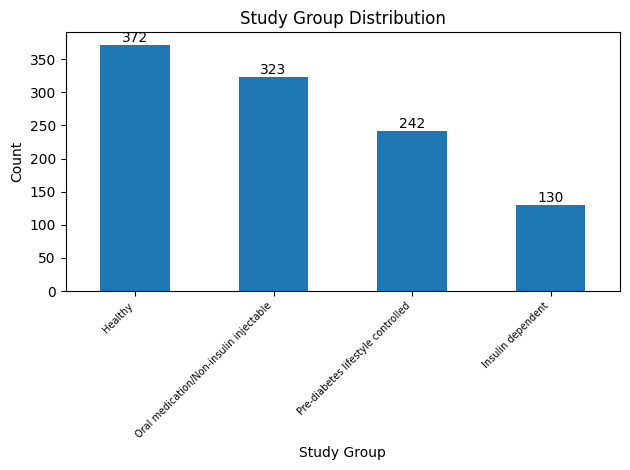

In [210]:
# Make a copy of the dataframe
copy_df = df_participant.copy()

# Rename study_group values for better readability
copy_df['study_group'] = copy_df['study_group'].replace({
    'healthy': 'Healthy', 
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Oral medication/Non-insulin injectable',
    'insulin_dependent': 'Insulin dependent',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes lifestyle controlled',
})

# Now plot value counts AFTER renaming
ax = copy_df['study_group'].value_counts().plot(kind='bar')

plt.title('Study Group Distribution')
plt.xlabel('Study Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right', size=7)

# Add total count on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [211]:
# Calculate mean glucose level for each study group
group_stats = (
    df_participant
    .merge(dfm, on='participant_id')  # Merge on 'participant_id' to combine data
    .groupby('study_group')['average_glucose_level_mg_dl']
    .agg(['mean', 'min', 'max'])
)

age_stats = df_participant['age'].agg(['mean', 'min', 'max'])

# Print the results
print('Group data:')
print(group_stats)
print('-'*50)
print('Age data:')
print(age_stats)

Group data:
                                                          mean         min  \
study_group                                                                  
healthy                                             120.337772   68.589744   
insulin_dependent                                   177.497007  108.544180   
oral_medication_and_or_non_insulin_injectable_m...  150.792876   91.385225   
pre_diabetes_lifestyle_controlled                   128.647238   67.560000   

                                                           max  
study_group                                                     
healthy                                             278.133758  
insulin_dependent                                   300.522583  
oral_medication_and_or_non_insulin_injectable_m...  308.993336  
pre_diabetes_lifestyle_controlled                   290.045364  
--------------------------------------------------
Age data:
mean    60.319588
min     40.000000
max     87.000000
Name: age, dty

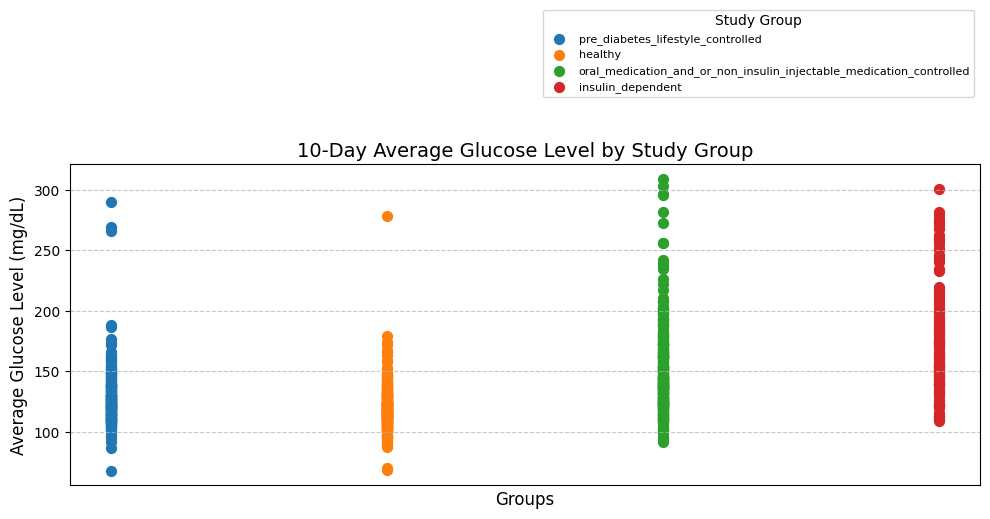

In [212]:
# Merge the participant data with glucose data to include study group information
merged_data = dfm.merge(
    df_participant[['participant_id', 'study_group']],
    on='participant_id'
)

# Scatterplot
plt.figure(figsize=(10, 6))

# Plot for each study group
for group in merged_data['study_group'].unique():
    group_data = merged_data[merged_data['study_group'] == group]
    plt.scatter(
        group_data['study_group'], 
        group_data['average_glucose_level_mg_dl'], 
        label=group, 
        s=50  # Marker size
    )

# Add labels, title, and legend
plt.title('10-Day Average Glucose Level by Study Group', fontsize=14)
plt.xlabel('Groups', fontsize=12)
plt.ylabel('Average Glucose Level (mg/dL)', fontsize=12)
plt.xticks([])
plt.legend(title='Study Group', fontsize=8, bbox_to_anchor=(1, 1.5), loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [213]:
# Set thresholds for high and low glucose levels
high_threshold = 250
low_threshold = 80

# Filter outliers for each group
outliers_by_group = {}
for group in merged_data['study_group'].unique():
    # Get the data for the current group
    group_data = merged_data[merged_data['study_group'] == group]
    
    # Find outliers for the current group
    high_outliers = group_data[group_data['average_glucose_level_mg_dl'] > high_threshold]
    low_outliers = group_data[group_data['average_glucose_level_mg_dl'] < low_threshold]
    
    # Store the results
    outliers_by_group[group] = {
        'high_outliers': high_outliers,
        'low_outliers': low_outliers
    }

# Display outliers for each group
for group, outliers in outliers_by_group.items():
    print(f"\nOutliers for group: {group}")
    print(f"High glucose outliers (above {high_threshold}):")
    print(outliers['high_outliers'][['participant_id', 'average_glucose_level_mg_dl']])
    
    print(f"\nLow glucose outliers (below {low_threshold}):")
    print(outliers['low_outliers'][['participant_id', 'average_glucose_level_mg_dl']])



Outliers for group: pre_diabetes_lifestyle_controlled
High glucose outliers (above 250):
     participant_id  average_glucose_level_mg_dl
151            1154                   269.082485
271            1277                   290.045364
455            4091                   266.253957

Low glucose outliers (below 80):
     participant_id  average_glucose_level_mg_dl
703            7052                        67.56

Outliers for group: healthy
High glucose outliers (above 250):
     participant_id  average_glucose_level_mg_dl
785            7145                   278.133758

Low glucose outliers (below 80):
     participant_id  average_glucose_level_mg_dl
109            1111                    70.000000
669            7008                    68.589744

Outliers for group: oral_medication_and_or_non_insulin_injectable_medication_controlled
High glucose outliers (above 250):
     participant_id  average_glucose_level_mg_dl
26             1027                   281.551471
348            13

In [214]:
df_personal_data = pd.read_csv("personal_data_with_BMI.csv")
df_personal_data.rename(columns={'person_id':'participant_id'}, inplace=True)
print(df_personal_data.head())
df_personal_data.shape

   participant_id  value_as_number_height  value_as_number_weight    BMI
0            1001                   162.0                    57.3  21.83
1            1002                   175.2                    94.1  30.66
2            1003                   160.7                    73.2  28.35
3            1004                   174.5                    76.8  25.22
4            1005                   173.0                    79.6  26.60


(1066, 4)

In [215]:
merged_data = pd.merge(df_personal_data, df_participant)
merged_data.dropna(inplace=True)
print(merged_data.head())
print(merged_data.shape)

   participant_id  value_as_number_height  value_as_number_weight    BMI  \
0            1001                   162.0                    57.3  21.83   
1            1002                   175.2                    94.1  30.66   
2            1003                   160.7                    73.2  28.35   
3            1004                   174.5                    76.8  25.22   
4            1005                   173.0                    79.6  26.60   

  clinical_site                                        study_group  age  \
0            UW                  pre_diabetes_lifestyle_controlled   69   
1            UW                                            healthy   69   
2            UW  oral_medication_and_or_non_insulin_injectable_...   82   
3            UW  oral_medication_and_or_non_insulin_injectable_...   61   
4            UW                                  insulin_dependent   58   

  study_visit_date recommended_split  cardiac_ecg  clinical_data  environment  \
0       202

## Splitting data into age groups and get diabetes percentage

age_group
(25, 35]      0
(35, 45]    124
(45, 55]    256
(55, 65]    290
(65, 75]    280
(75, 85]     91
dtype: int64
--------------------------------------------------
bmi_group
(0.0, 18.5]      11
(18.5, 24.9]    228
(24.9, 29.9]    338
(29.9, 39.9]    343
(39.9, inf]     127
dtype: int64
--------------------------------------------------
Diabetes percentage by age:  age_group
(25, 35]         NaN
(35, 45]    0.403226
(45, 55]    0.371094
(55, 65]    0.455172
(65, 75]    0.450000
(75, 85]    0.450549
dtype: float64


C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\3102707920.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_counts = merged_data.groupby("age_group").size().sort_index()
C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\3102707920.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_group_counts = merged_data.groupby("bmi_group").size().sort_index()


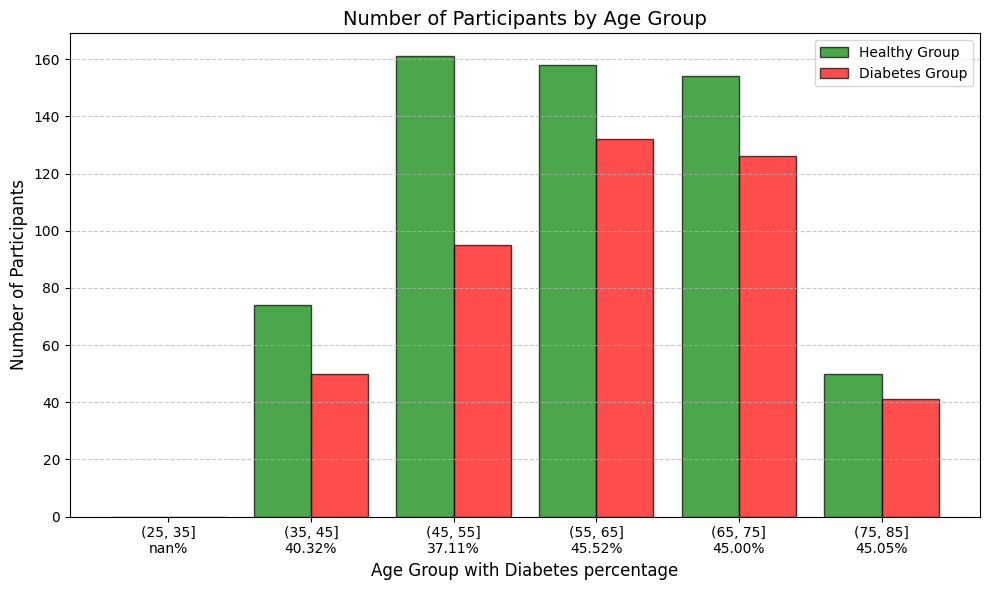

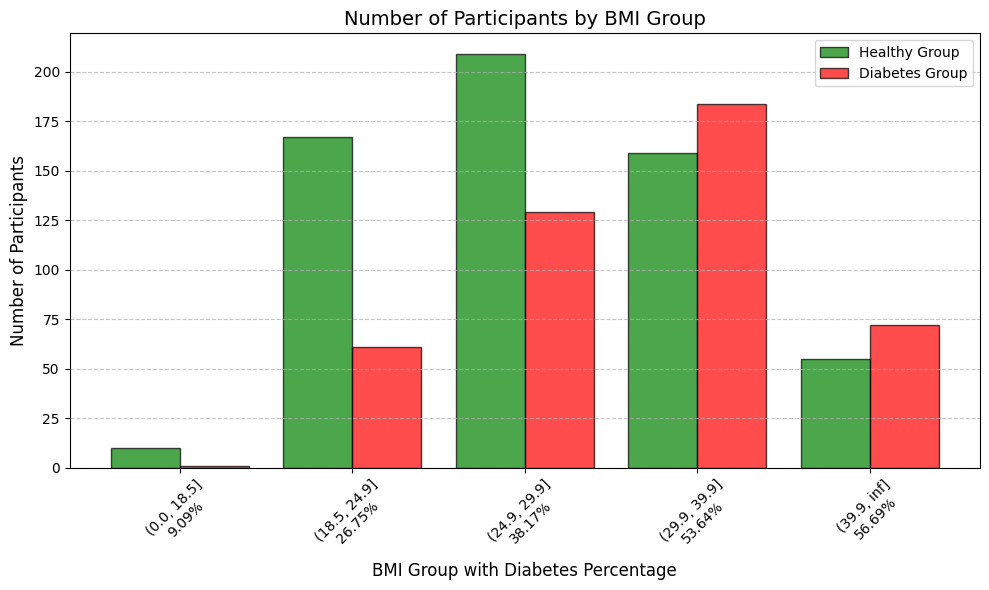

In [216]:

bmi_bins = pd.cut(merged_data["BMI"], bins=[0, 18.5, 24.9, 29.9, 39.9, float("inf")])
age_bins = pd.cut(merged_data["age"], bins=range(25, 95, 10))  # Custom age groups from 25 to 95 increment by 10

# Add bins to the dataframe
merged_data["age_group"] = age_bins
merged_data["bmi_group"] = bmi_bins

merged_data = (
    merged_data
    .merge(dfm, on='participant_id', how='inner')  # Keep only matching IDs
    .dropna(subset=['glucose_filepath'])  # Remove rows with missing filepaths
)

merged_data = merged_data[['glucose_filepath', 'participant_id', 'average_glucose_level_mg_dl', 
                               'glucose_sensor_sampling_duration_days', 'age', 'BMI', 'study_group',
                               'age_group', 'bmi_group']]

age_group_counts = merged_data.groupby("age_group").size().sort_index()
bmi_group_counts = merged_data.groupby("bmi_group").size().sort_index()

healthy_group = ["healthy", "pre_diabetes_lifestyle_controlled"]
diabetes_group = ["oral_medication_and_or_non_insulin_injectable_medication_controlled", "insulin_dependent"]

print(age_group_counts)
print('-'*50)
print(bmi_group_counts)
print('-'*50)

# Print age count for only participants in the healthy group
healthy_age_counts = merged_data[merged_data['study_group'].isin(healthy_group)]['age_group'].value_counts().sort_index()
diabetes_age_count = merged_data[merged_data['study_group'].isin(diabetes_group)]['age_group'].value_counts().sort_index()

percentage_diabetes = (diabetes_age_count / age_group_counts).sort_index()
print("Diabetes percentage by age: ", percentage_diabetes)

import numpy as np
# Define bar width
bar_width = 0.4  
x = np.arange(len(healthy_age_counts))  # Positions for bars
# Format x labels to include age group and diabetes percentage
x_labels = [f"{age}\n{percent:.2f}%" for age, percent in zip(healthy_age_counts.index.astype(str), percentage_diabetes*100)]


plt.figure(figsize=(10, 6))

# Plot bars side by side
plt.bar(x - bar_width / 2, healthy_age_counts, width=bar_width, color='green', edgecolor='black', label='Healthy Group', alpha=0.7)
plt.bar(x + bar_width / 2, diabetes_age_count, width=bar_width, color='red', edgecolor='black', label='Diabetes Group', alpha=0.7)

# Formatting
plt.title('Number of Participants by Age Group', fontsize=14)
plt.xlabel('Age Group with Diabetes percentage', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.xticks(x, x_labels)  # Ensure x-axis labels are correctly aligned
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

# Count participants in each BMI group for healthy and diabetes groups
healthy_bmi_counts = merged_data[merged_data['study_group'].isin(healthy_group)]['bmi_group'].value_counts().sort_index()
diabetes_bmi_counts = merged_data[merged_data['study_group'].isin(diabetes_group)]['bmi_group'].value_counts().sort_index()

# Calculate the percentage of diabetes patients in each BMI group
percentage_diabetes_bmi = (diabetes_bmi_counts / bmi_group_counts).sort_index()

x = np.arange(len(healthy_bmi_counts))  # Positions for bars

# Format x labels to include BMI group and diabetes percentage
x_labels = [f"{bmi}\n{percent:.2f}%" for bmi, percent in zip(healthy_bmi_counts.index.astype(str), percentage_diabetes_bmi * 100)]

plt.figure(figsize=(10, 6))

# Plot bars side by side
plt.bar(x - bar_width / 2, healthy_bmi_counts, width=bar_width, color='green', edgecolor='black', label='Healthy Group', alpha=0.7)
plt.bar(x + bar_width / 2, diabetes_bmi_counts, width=bar_width, color='red', edgecolor='black', label='Diabetes Group', alpha=0.7)

# Formatting
plt.title('Number of Participants by BMI Group', fontsize=14)
plt.xlabel('BMI Group with Diabetes Percentage', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.xticks(x, x_labels, rotation=45)  # Ensure x-axis labels are correctly aligned and rotated for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


## Boxplot for daily activity count throughout the period


In [217]:
activity_manifest_path = pilot_data_root + "wearable_activity_monitor/manifest.tsv"
df_activity = pd.read_csv(activity_manifest_path, sep='\t')
df_activity.dropna(subset=['physical_activity_filepath'], inplace=True)

print(df_activity.shape)

df_activity_merged = pd.merge(merged_data, df_activity, on='participant_id', how='inner')

df_activity_merged = df_activity_merged[['participant_id', 'study_group', 'age_group', 'bmi_group', 'physical_activity_filepath', 
                           'average_daily_activity']]

print(df_activity_merged.head())

average_daily_activity_by_age_group = df_activity_merged.groupby('age_group')['average_daily_activity'].mean()
print(average_daily_activity_by_age_group)

(905, 27)
   participant_id                                        study_group  \
0            1023                                  insulin_dependent   
1            1024                  pre_diabetes_lifestyle_controlled   
2            1026                  pre_diabetes_lifestyle_controlled   
3            1027  oral_medication_and_or_non_insulin_injectable_...   
4            1028  oral_medication_and_or_non_insulin_injectable_...   

  age_group     bmi_group                         physical_activity_filepath  \
0  (65, 75]  (29.9, 39.9]  /wearable_activity_monitor/physical_activity/g...   
1  (55, 65]  (18.5, 24.9]  /wearable_activity_monitor/physical_activity/g...   
2  (65, 75]  (18.5, 24.9]  /wearable_activity_monitor/physical_activity/g...   
3  (45, 55]  (29.9, 39.9]  /wearable_activity_monitor/physical_activity/g...   
4  (55, 65]  (18.5, 24.9]  /wearable_activity_monitor/physical_activity/g...   

   average_daily_activity  
0                 7797.21  
1                 45

C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\1944084214.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_daily_activity_by_age_group = df_activity_merged.groupby('age_group')['average_daily_activity'].mean()


C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\3036685458.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_group', y='average_daily_activity', data=df_activity_merged, palette='Set2')


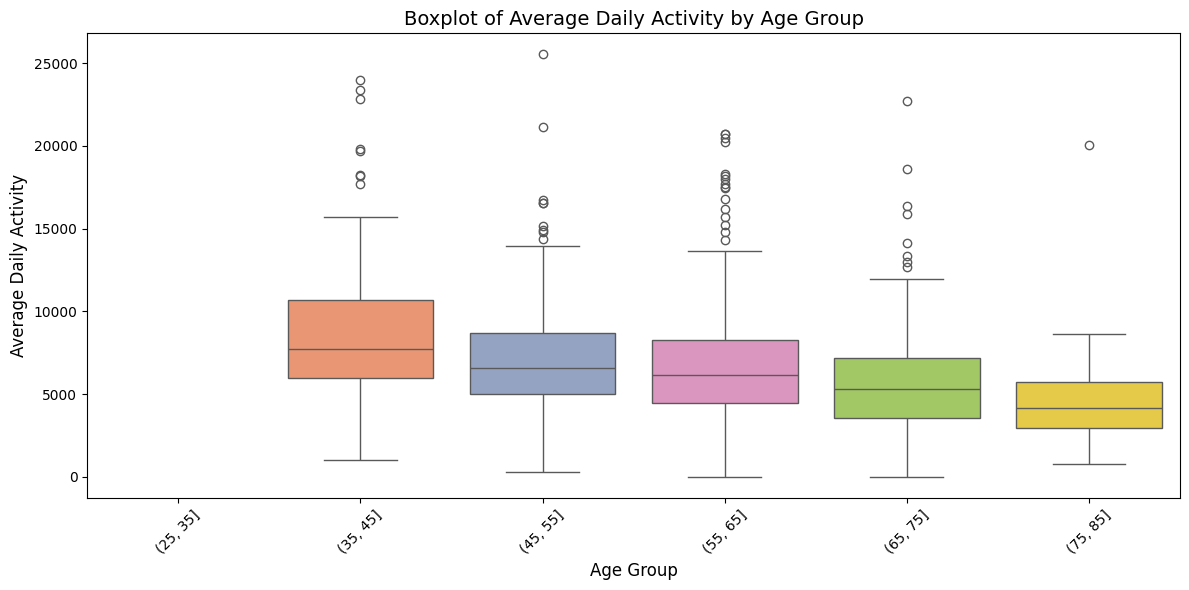

In [218]:
import seaborn as sns

# Plot the boxplot for average daily activity across age groups
plt.figure(figsize=(12, 6))

sns.boxplot(x='age_group', y='average_daily_activity', data=df_activity_merged, palette='Set2')

# Title and labels
plt.title('Boxplot of Average Daily Activity by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Average Daily Activity', fontsize=12)

# Rotate x-ticks if necessary
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [219]:
for id in merged_data['participant_id']:
  start_time, end_time = get_start_end_time(id)
  merged_data.loc[merged_data['participant_id'] == id, 'start_time'] = start_time
  merged_data.loc[merged_data['participant_id'] == id, 'end_time'] = end_time

merged_data.rename(columns={'study_group': 'study_group_pre'}, inplace=True)

# Replace study group names
merged_data.loc[merged_data['study_group_pre'].isin(healthy_group), 'study_group'] = 'healthy'
merged_data.loc[merged_data['study_group_pre'].isin(diabetes_group), 'study_group'] = 'diabetes'

In [220]:
merged_data.to_csv("participant_data_all.csv", index=False)

(93, 12)
                                     glucose_filepath  participant_id  \
51  wearable_blood_glucose/continuous_glucose_moni...            1052   
62  wearable_blood_glucose/continuous_glucose_moni...            1063   
69  wearable_blood_glucose/continuous_glucose_moni...            1070   
71  wearable_blood_glucose/continuous_glucose_moni...            1072   
76  wearable_blood_glucose/continuous_glucose_moni...            1077   

    average_glucose_level_mg_dl  glucose_sensor_sampling_duration_days  age  \
51                   144.994398                                     11   61   
62                   167.943322                                      8   57   
69                   168.152661                                     11   57   
71                   137.790266                                     10   61   
76                   121.268190                                     11   64   

      BMI                                    study_group_pre age_group  \
51 

C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\2107155327.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='study_group', y='average_glucose_level_mg_dl', data=filtered_data, palette={'healthy': 'green', 'diabetes': 'red'})


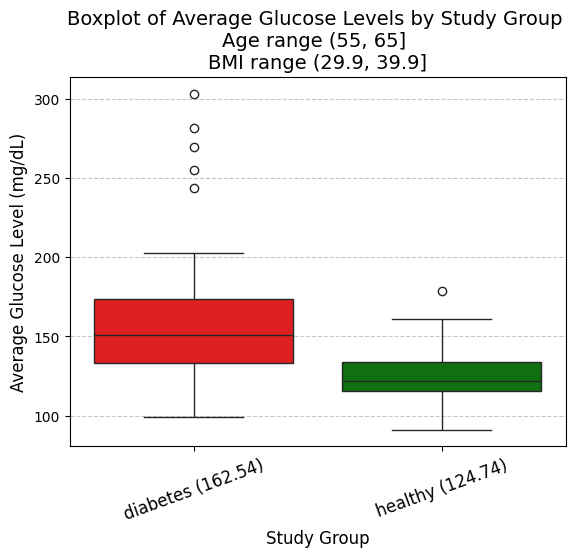

Healthy samples: [1077 4233 7056 4082 4242]
Diabetes samples: [7227 7061 7163 1063 7059]


In [221]:
# Filter participants by age group (55-65) and same BMI from 29.9 to 39.9
filtered_data = merged_data[(merged_data['age_group'] == pd.Interval(55, 65, closed='right')) & 
              (merged_data['bmi_group'] == pd.Interval(29.9, 39.9, closed='right'))].copy()

# Save the filtered data to a CSV file
filtered_data.to_csv('filtered_data.csv', index=False)

print(filtered_data.shape)  # Print the shape of the filtered data
print(filtered_data.head())

# Create the boxplot
sns.boxplot(x='study_group', y='average_glucose_level_mg_dl', data=filtered_data, palette={'healthy': 'green', 'diabetes': 'red'})

# Calculate the average glucose level for each study group
means = filtered_data.groupby('study_group')['average_glucose_level_mg_dl'].mean()

# Update x-tick labels to include the group name and the mean
new_labels = [f'{group} ({means[group]:.2f})' for group in means.index]
plt.xticks(ticks=range(len(means)), labels=new_labels, rotation=20, fontsize=12)

# Title and labels
plt.title('Boxplot of Average Glucose Levels by Study Group \nAge range (55, 65] \nBMI range (29.9, 39.9]', fontsize=14)
plt.xlabel('Study Group', fontsize=12)
plt.ylabel('Average Glucose Level (mg/dL)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Randomly select 5 participants from each study group
healthy_samples = filtered_data[filtered_data['study_group'] == 'healthy'].sample(5)  # Randomly select 5 participants where study_group is 'healthy'
diabetes_sample = filtered_data[filtered_data['study_group'] == 'diabetes'].sample(5)  # Randomly select 5 participants where study_group is 'diabetes'

healthy_samples_id = healthy_samples['participant_id'].values
diabetes_samples_id = diabetes_sample['participant_id'].values

print(f"Healthy samples: {healthy_samples_id}")
print(f"Diabetes samples: {diabetes_samples_id}")



In [222]:
# Global list to store all (start, end) times
def process_cgm_data(sample_id):
    pid = sample_id

    pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
    cgm_path = pilot_data_root + pid_cgm

    with open(cgm_path,'r') as f:
        data = json.load(f)

    cgm_header = flatten_json(data['header'])

    list_of_body_dicts = list()
    for observation in data['body']['cgm']:
        flat_obs = flatten_json(observation)
        list_of_body_dicts.append(flat_obs)

    df = pd.DataFrame.from_records(list_of_body_dicts)
    df.rename(columns={'effective_time_frame_time_interval_start_date_time':'start_time', 'effective_time_frame_time_interval_end_date_time': 'end_time'}, inplace=True)
    df['start_dtime'] = df.apply(lambda row: convert_time_string_to_datetime(row['start_time']), axis=1)

    # df['blood_glucose_value'].value_counts()  # peek at the value distribution
    low_value = 40  # select a value to use for low
    high_value = 400  # select a value to use for high

    if (0):
        df.replace({"Low": low_value, "High": high_value}, inplace=True)  # notebook dev used pd 2.1.4
    else:  # to avoid the FutureWarning regarding Downcasting behavior in 'replace'
        def replace_alt(val, low_value, high_value):
            if val == "Low":
                return low_value
            elif val == "High":
                return high_value
            else:
                return val

        df['blood_glucose_value'] = df.apply(lambda x: replace_alt(x['blood_glucose_value'], low_value, high_value), axis=1)

    return df


In [223]:
def find_most_common_time_range():
  global participant_time_ranges
  if not participant_time_ranges:
      return None, None

  # Flatten all start and end times into events
  events = []
  for start, end, _, _ in participant_time_ranges:
      events.append((start, 1))  # 1 for start of participation
      events.append((end, -1))   # -1 for end of participation

  # Sort events by time (if same time, process end before start to avoid overcounting)
  events.sort(key=lambda x: (x[0], x[1]))

  max_count = 0
  current_count = 0
  best_start = None
  best_end = None
  temp_start = None

  # Sweep Line Algorithm to find peak participation period
  for time, change in events:
      if change == 1:  # A participant enters
          current_count += 1
          if current_count > max_count:
              max_count = current_count
              best_start = temp_start if temp_start else time
      else:  # A participant leaves
          if current_count == max_count:
              best_end = time
          current_count -= 1
          if current_count == max_count:
              temp_start = time  # Candidate start for next peak range

  return best_start, best_end


In [224]:
# Create an empty list to store the time ranges and associated participant IDs and study groups
participant_time_ranges = []

# Process all participants in dfm
for participant_id in filtered_data['participant_id'].unique():
  filtered_data_participant = filtered_data[filtered_data['participant_id'] == participant_id]
  study_group = filtered_data_participant['study_group'].values[0]
  participant_start_time = filtered_data_participant['start_time'].values[0]
  participant_end_time = filtered_data_participant['end_time'].values[0]
  # Append the time range along with participant ID and study group
  participant_time_ranges.append((participant_start_time, participant_end_time, participant_id, study_group))


# Get the best range
global_start_time, global_end_time = find_most_common_time_range()

def count_participants_in_range(start_time, end_time):
  participants_in_range = []  # List to store participant IDs and their study groups
  count = 0
  
  for participant_start, participant_end, participant_id, study_group in participant_time_ranges:
      if participant_start <= end_time and participant_end >= start_time:
          count += 1
          participants_in_range.append((participant_id, study_group))
  
  return count, participants_in_range

# Count participants in the most common range
total_participants, participants_in_range = count_participants_in_range(global_start_time, global_end_time)

# Print the results
print(f"Most common time range: {global_start_time} to {global_end_time}")
print(f"Total number of participants in this time range: {total_participants}")

# Print participant IDs and their study groups within the range
print(participants_in_range)



Most common time range: 2024-07-24T19:02:50.000000000 to 2024-07-25T19:41:54.000000000
Total number of participants in this time range: 11
[(4268, 'diabetes'), (4274, 'diabetes'), (4279, 'diabetes'), (4282, 'healthy'), (4285, 'healthy'), (7382, 'diabetes'), (7383, 'healthy'), (7393, 'diabetes'), (7395, 'diabetes'), (7398, 'healthy'), (7401, 'healthy')]


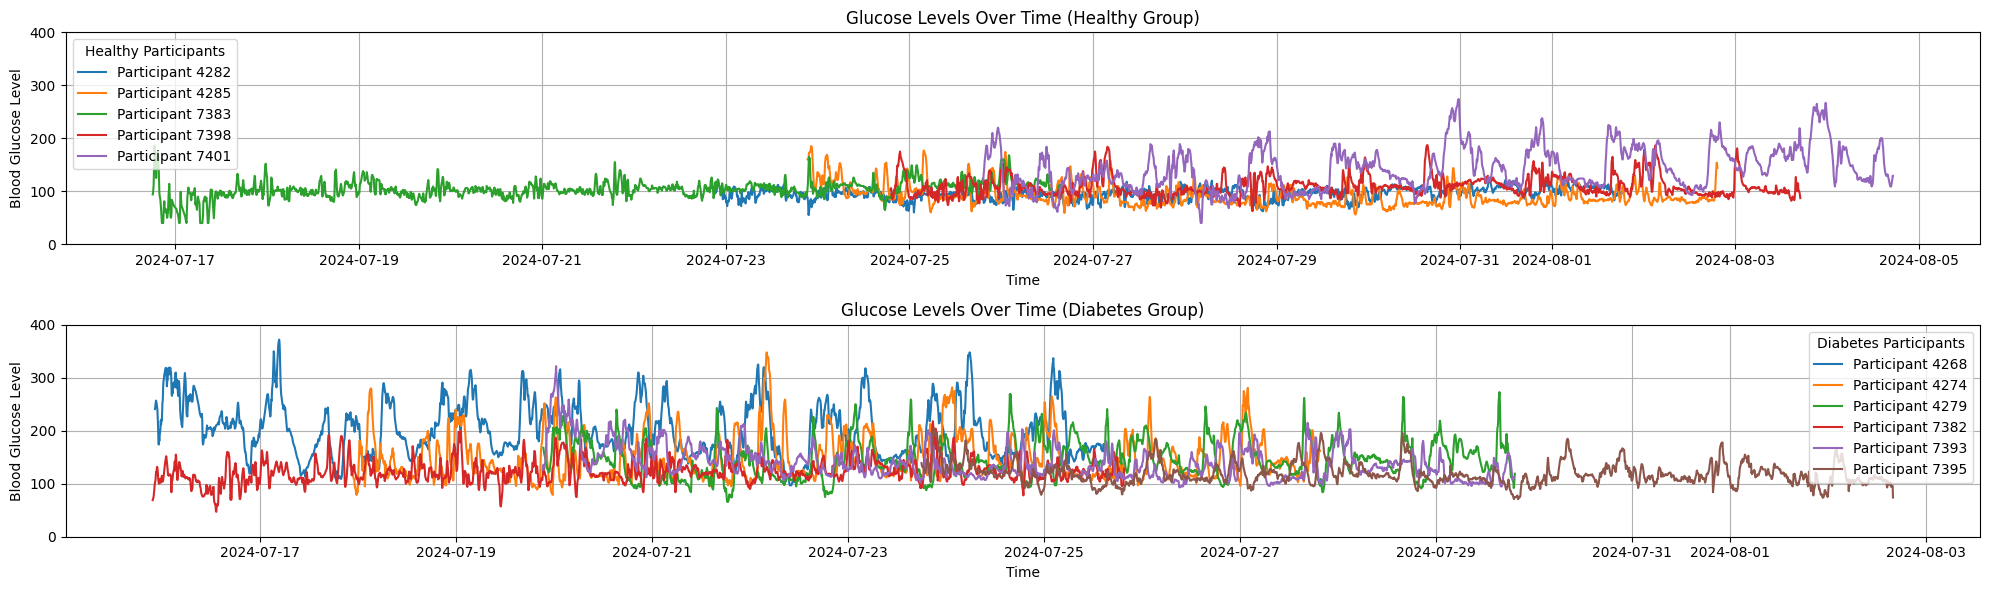

In [225]:
plt.figure(figsize=(20, 6))  # Create a single figure before the loop

yticks = np.arange(0, 401, 100)

# Plot for healthy group (first subplot)
plt.subplot(2, 1, 1)  # (rows, cols, index) - First subplot
for sample_id, study_group in participants_in_range:
  if study_group == 'healthy':
    df = process_cgm_data(sample_id)  # Process data for each patient

    if df is None:
        print(f"Warning: No data found for Participant {sample_id}. Skipping.")
        continue

    plt.plot(df['start_dtime'], df['blood_glucose_value'], label=f'Participant {sample_id}')  # Plot on the same figure

plt.xlabel("Time")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Healthy Participants")
plt.title("Glucose Levels Over Time (Healthy Group)")
plt.yticks(yticks)
plt.grid(True)

# Plot for diabetes group (second subplot)
plt.subplot(2, 1, 2)  # (rows, cols, index) - Second subplot
for sample_id, study_group in participants_in_range:
  if study_group == 'diabetes':
    df = process_cgm_data(sample_id)  # Process data for each patient

    if df is None:
        print(f"Warning: No data found for Participant {sample_id}. Skipping.")
        continue
    
    plt.plot(df['start_dtime'], df['blood_glucose_value'], label=f'Participant {sample_id}')  # Plot on the same figure

plt.xlabel("Time")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Diabetes Participants")
plt.title("Glucose Levels Over Time (Diabetes Group)")
plt.yticks(yticks)
plt.grid(True)

# Show the combined figure with both subplots
plt.tight_layout()  # Adjust spacing to avoid overlap
plt.show()

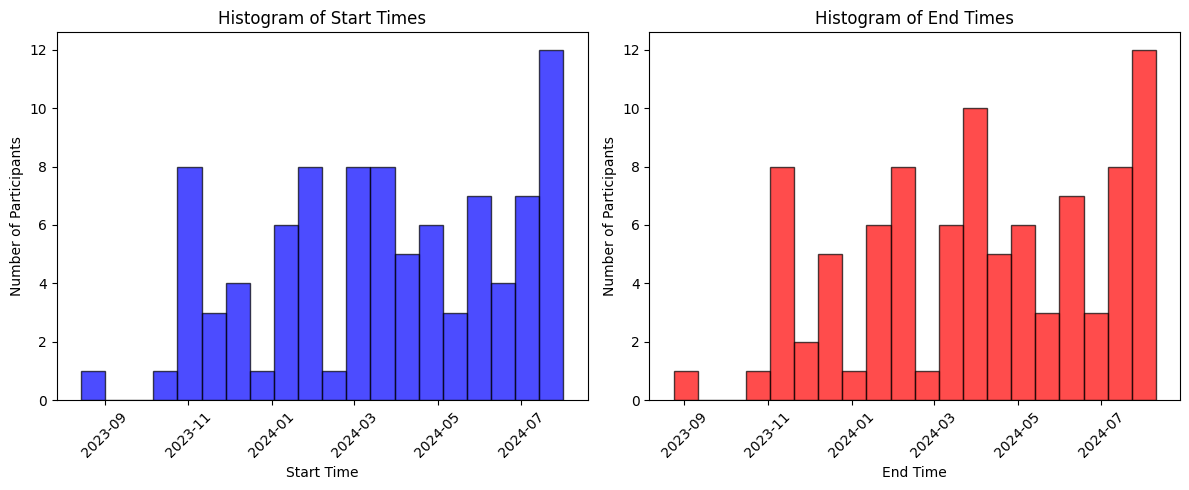

In [226]:
import matplotlib.pyplot as plt

def plot_time_histograms():
    global participant_time_ranges
    if not participant_time_ranges:
        print("No data available for histogram.")
        return
    
    # Extract start and end times
    start_times = [start for start, _, _, _ in participant_time_ranges]
    end_times = [end for _, end, _, _ in participant_time_ranges]

    # Plot histogram
    plt.figure(figsize=(12, 5))

    # Start time histogram
    plt.subplot(1, 2, 1)
    plt.hist(start_times, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel("Start Time")
    plt.ylabel("Number of Participants")
    plt.title("Histogram of Start Times")
    plt.xticks(rotation=45)

    # End time histogram
    plt.subplot(1, 2, 2)
    plt.hist(end_times, bins=20, color='red', alpha=0.7, edgecolor='black')
    plt.xlabel("End Time")
    plt.ylabel("Number of Participants")
    plt.title("Histogram of End Times")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Call after processing all participants
plot_time_histograms()


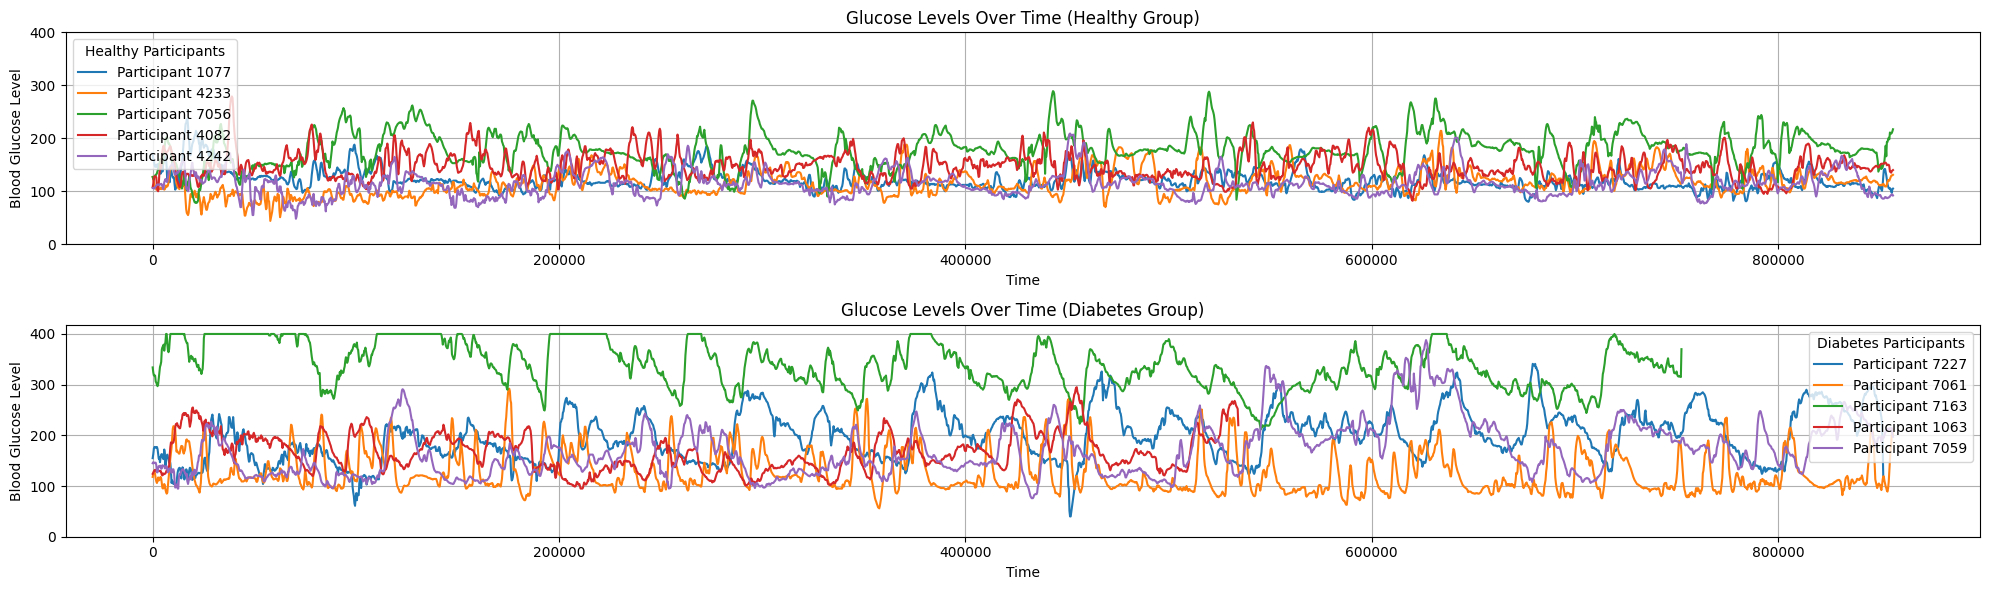

In [227]:
plt.figure(figsize=(20, 6))  # Create a single figure before the loop

yticks = np.arange(0, 401, 100)

# Plot for healthy group (first subplot)
plt.subplot(2, 1, 1)  # (rows, cols, index) - First subplot
for sample_id in healthy_samples_id:
    df = process_cgm_data(sample_id)  # Process data for each patient

    if df is None:
        print(f"Warning: No data found for Participant {sample_id}. Skipping.")
        continue

    # Convert timestamps to relative time (minutes since first entry)
    df['relative_time'] = (df['transmitter_time_value'] - df['transmitter_time_value'].min())
    
    plt.plot(df['relative_time'], df['blood_glucose_value'], label=f'Participant {sample_id}')  # Plot on the same figure

plt.xlabel("Time")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Healthy Participants")
plt.title("Glucose Levels Over Time (Healthy Group)")
plt.yticks(yticks)
plt.grid(True)

# Plot for diabetes group (second subplot)
plt.subplot(2, 1, 2)  # (rows, cols, index) - Second subplot
for sample_id in diabetes_samples_id:  # Select the first 5 samples from the diabetes group
    df = process_cgm_data(sample_id)  # Process data for each patient

    if df is None:
        print(f"Warning: No data found for Participant {sample_id}. Skipping.")
        continue

    # Convert timestamps to relative time (minutes since first entry)
    df['relative_time'] = (df['transmitter_time_value'] - df['transmitter_time_value'].min())
    
    plt.plot(df['relative_time'], df['blood_glucose_value'], label=f'Participant {sample_id}')  # Plot on the same figure

plt.xlabel("Time")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Diabetes Participants")
plt.title("Glucose Levels Over Time (Diabetes Group)")
plt.yticks(yticks)
plt.grid(True)

# Show the combined figure with both subplots
plt.tight_layout()  # Adjust spacing to avoid overlap
plt.show()

## Get the data from qualified running session, and plot them to see the effect of running on glucose

In [228]:
running_sessions_df = pd.read_csv("qualified_running_sessions.csv", parse_dates=['actual_start_time', 'actual_end_time'])
running_sessions_df = running_sessions_df.drop(columns=['study_group'])

# Extend start and end time by 1 hour each
running_sessions_df['extended_start_time'] = running_sessions_df['actual_start_time'] - pd.Timedelta(hours=1)
running_sessions_df['extended_end_time'] = running_sessions_df['actual_end_time'] + pd.Timedelta(hours=1)

data_with_qualified_running = filtered_data.merge(running_sessions_df, on='participant_id', how='inner')

data_with_qualified_running

,glucose_filepath,participant_id,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days,age,BMI,study_group_pre_x,age_group,bmi_group,start_time,end_time,study_group,actual_start_time,actual_end_time,duration_minutes,total_steps,avg_steps_per_min,study_group_pre_y,extended_start_time,extended_end_time
0,wearable_blood_glucose/continuous_glucose_moni...,1221,199.688616,11,62,35.61,oral_medication_and_or_non_insulin_injectable_...,"(55, 65]","(29.9, 39.9]",2024-04-08 21:03:21,2024-04-18 18:58:21,diabetes,2024-04-11 17:08:59,2024-04-11 17:40:59,32.0,452,75.333333,oral_medication_and_or_non_insulin_injectable_...,2024-04-11 16:08:59,2024-04-11 18:40:59
1,wearable_blood_glucose/continuous_glucose_moni...,1247,121.375834,11,63,31.16,healthy,"(55, 65]","(29.9, 39.9]",2024-04-23 17:53:17,2024-05-03 15:48:17,healthy,2024-04-28 16:00:04,2024-04-28 16:39:04,39.0,453,64.714286,healthy,2024-04-28 15:00:04,2024-04-28 17:39:04
2,wearable_blood_glucose/continuous_glucose_moni...,4157,120.809574,11,62,31.42,healthy,"(55, 65]","(29.9, 39.9]",2024-04-22 17:40:46,2024-05-02 15:50:42,healthy,2024-04-28 18:55:14,2024-04-28 19:41:14,46.0,903,48.031915,healthy,2024-04-28 17:55:14,2024-04-28 20:41:14
3,wearable_blood_glucose/continuous_glucose_moni...,4166,109.804047,11,59,30.60,healthy,"(55, 65]","(29.9, 39.9]",2024-04-26 21:46:50,2024-05-06 18:41:50,healthy,2024-05-01 19:13:18,2024-05-01 19:46:18,33.0,613,87.571429,healthy,2024-05-01 18:13:18,2024-05-01 20:46:18
4,wearable_blood_glucose/continuous_glucose_moni...,4187,108.364250,11,59,29.96,oral_medication_and_or_non_insulin_injectable_...,"(55, 65]","(29.9, 39.9]",2024-05-15 22:31:29,2024-05-25 17:11:29,diabetes,2024-05-23 22:53:31,2024-05-24 00:05:31,72.0,2324,101.337209,oral_medication_and_or_non_insulin_injectable_...,2024-05-23 21:53:31,2024-05-24 01:05:31
5,wearable_blood_glucose/continuous_glucose_moni...,4279,146.664566,11,65,33.21,oral_medication_and_or_non_insulin_injectable_...,"(55, 65]","(29.9, 39.9]",2024-07-19 21:27:18,2024-07-29 19:22:18,diabetes,2024-07-21 17:03:26,2024-07-21 17:54:26,51.0,1643,58.678571,oral_medication_and_or_non_insulin_injectable_...,2024-07-21 16:03:26,2024-07-21 18:54:26
6,wearable_blood_glucose/continuous_glucose_moni...,4279,146.664566,11,65,33.21,oral_medication_and_or_non_insulin_injectable_...,"(55, 65]","(29.9, 39.9]",2024-07-19 21:27:18,2024-07-29 19:22:18,diabetes,2024-07-22 16:07:26,2024-07-22 16:52:26,45.0,1708,81.333333,oral_medication_and_or_non_insulin_injectable_...,2024-07-22 15:07:26,2024-07-22 17:52:26
7,wearable_blood_glucose/continuous_glucose_moni...,4279,146.664566,11,65,33.21,oral_medication_and_or_non_insulin_injectable_...,"(55, 65]","(29.9, 39.9]",2024-07-19 21:27:18,2024-07-29 19:22:18,diabetes,2024-07-24 16:41:26,2024-07-24 17:33:26,52.0,1772,63.285714,oral_medication_and_or_non_insulin_injectable_...,2024-07-24 15:41:26,2024-07-24 18:33:26
8,wearable_blood_glucose/continuous_glucose_moni...,4279,146.664566,11,65,33.21,oral_medication_and_or_non_insulin_injectable_...,"(55, 65]","(29.9, 39.9]",2024-07-19 21:27:18,2024-07-29 19:22:18,diabetes,2024-07-25 00:01:26,2024-07-25 00:49:26,48.0,1450,46.774194,oral_medication_and_or_non_insulin_injectable_...,2024-07-24 23:01:26,2024-07-25 01:49:26
9,wearable_blood_glucose/continuous_glucose_moni...,4279,146.664566,11,65,33.21,oral_medication_and_or_non_insulin_injectable_...,"(55, 65]","(29.9, 39.9]",2024-07-19 21:27:18,2024-07-29 19:22:18,diabetes,2024-07-25 22:22:10,2024-07-25 23:10:10,48.0,1740,85.294118,oral_medication_and_or_non_insulin_injectable_...,2024-07-25 21:22:10,2024-07-26 00:10:10


Processing participant 1221
Processing participant 1247
Processing participant 4157
Processing participant 4166
Processing participant 4187
Processing participant 4279
Processing participant 4279
Processing participant 4279
Processing participant 4279
Processing participant 4279
Processing participant 4279
Processing participant 4279
Processing participant 7062
Processing participant 7308


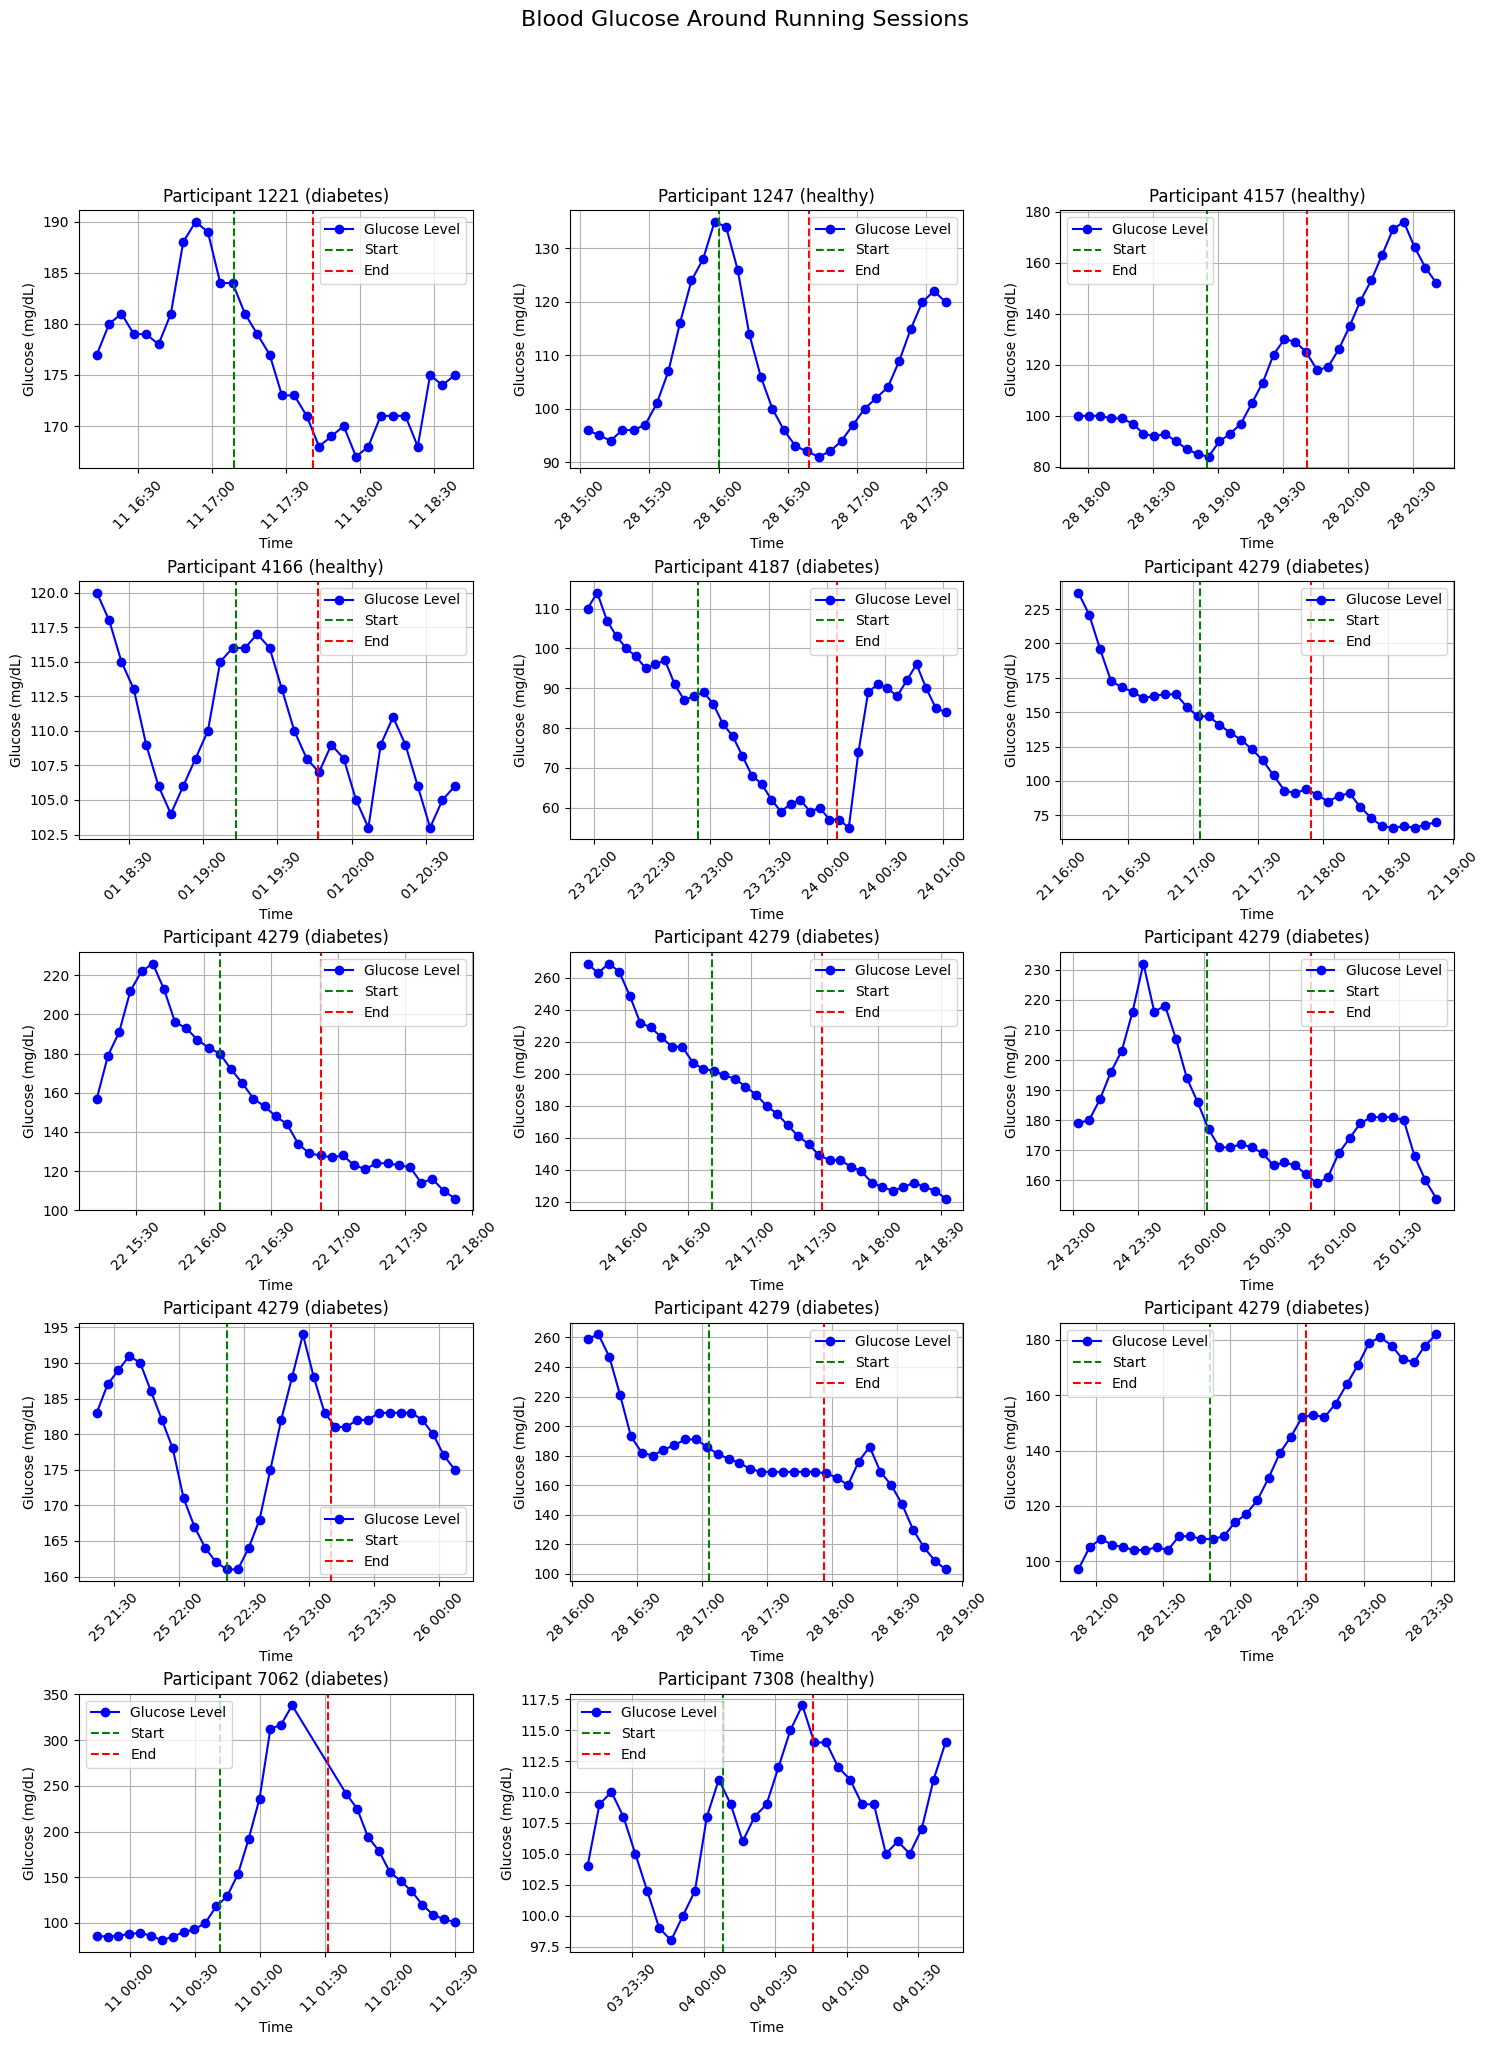

In [229]:
# Count how many sessions you'll plot
num_sessions = len(data_with_qualified_running)

# Create a grid of subplots (e.g., 3 per row)
cols = 3
rows = (num_sessions + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=False)
axes = axes.flatten()  # Flatten in case it's a 2D array

for i, (idx, row) in enumerate(data_with_qualified_running.iterrows()):
    id = row['participant_id']
    study_group = row['study_group']
    print(f"Processing participant {id}")

    # Process CGM data
    cgm_df = process_cgm_data(id)

    # Time ranges
    time_range_start = pd.to_datetime(row['extended_start_time'])
    time_range_end = pd.to_datetime(row['extended_end_time'])
    actual_start_time = pd.to_datetime(row['actual_start_time'])
    actual_end_time = pd.to_datetime(row['actual_end_time'])

    # Filter CGM data
    filtered_cgm_df = cgm_df[
        (cgm_df['start_dtime'] >= time_range_start) &
        (cgm_df['start_dtime'] <= time_range_end)
    ]

    if filtered_cgm_df.empty:
        print(f"No CGM data for participant {id} in specified range.")
        continue

    # Plot on subplot
    ax = axes[i]
    ax.plot(filtered_cgm_df['start_dtime'], filtered_cgm_df['blood_glucose_value'],
            marker='o', linestyle='-', color='b', label='Glucose Level')
    ax.axvline(x=actual_start_time, color='g', linestyle='--', label='Start')
    ax.axvline(x=actual_end_time, color='r', linestyle='--', label='End')

    ax.set_title(f'Participant {id} ({study_group})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Glucose (mg/dL)')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Blood Glucose Around Running Sessions", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()


# Read all the qualified running sessions then get average glucose before and after running (1 hour)

In [230]:
running_sessions_all_df = pd.read_csv("qualified_running_sessions_all.csv")

In [231]:
def process_running_session(data_with_qualified_running):
    cgm_cache = {}  # Cache CGM data per participant

    for idx, row in data_with_qualified_running.iterrows():
        pid = row['participant_id']
        print(f"Processing participant {pid}")

        # Check if we've already loaded CGM data for this participant
        if pid not in cgm_cache:
            cgm_df = process_cgm_data(pid)
            cgm_df['start_dtime'] = pd.to_datetime(cgm_df['start_dtime'])
            cgm_cache[pid] = cgm_df
        else:
            cgm_df = cgm_cache[pid]

        # Lấy thời gian start-end của phiên chạy
        actual_start_time = pd.to_datetime(row['actual_start_time'])
        actual_end_time = pd.to_datetime(row['actual_end_time'])

        # Lọc dữ liệu glucose trong khoảng thời gian mở rộng
        filtered_cgm_df = cgm_df[(cgm_df['start_dtime'] >= actual_start_time - pd.Timedelta(hours=1)) & 
                                 (cgm_df['start_dtime'] <= actual_end_time + pd.Timedelta(hours=1))]

        if filtered_cgm_df.empty:
            print(f"No CGM data found for participant {pid} in the specified time range.")
            glucose_before = None
            glucose_min = None
            glucose_max = None
            glucose_after = None
            glucose_15min_after_start = None
            glucose_30min_after_start = None
            glucose_at_start = None
            glucose_at_end = None
            delta = None
            delta_exact = None
        else:
            # Check for gaps > 10 minutes
            filtered_cgm_df = filtered_cgm_df.sort_values('start_dtime')
            time_diffs = filtered_cgm_df['start_dtime'].diff().dropna()
            gap_threshold = pd.Timedelta(minutes=10)

            if (time_diffs > gap_threshold).any():
                print(f"Skipping participant {pid} due to large CGM gap.")
                glucose_before = None
                glucose_min = None
                glucose_max = None
                glucose_after = None
                glucose_15min_after_start = None
                glucose_30min_after_start = None
                glucose_at_start = None
                glucose_at_end = None
                delta = None
                delta_exact = None
            else:
                glucose_min = round(filtered_cgm_df[
                    (filtered_cgm_df['start_dtime'] >= actual_start_time ) & 
                    (filtered_cgm_df['start_dtime'] <= actual_end_time)
                ]['blood_glucose_value'].min(), 2)
                
                glucose_max = round(filtered_cgm_df[
                    (filtered_cgm_df['start_dtime'] >= actual_start_time ) & 
                    (filtered_cgm_df['start_dtime'] <= actual_end_time)
                ]['blood_glucose_value'].max(), 2)
                
                glucose_before = round(filtered_cgm_df[
                    (filtered_cgm_df['start_dtime'] >= actual_start_time - pd.Timedelta(hours=0.5)) & 
                    (filtered_cgm_df['start_dtime'] < actual_start_time)
                ]['blood_glucose_value'].mean(), 2)
                
                glucose_after = round(filtered_cgm_df[
                    (filtered_cgm_df['start_dtime'] > actual_end_time) & 
                    (filtered_cgm_df['start_dtime'] <= actual_end_time + pd.Timedelta(hours=0.5))
                ]['blood_glucose_value'].mean(), 2)
                
                glucose_15min_after_start = round(filtered_cgm_df[
                    (filtered_cgm_df['start_dtime'] >= actual_start_time) & 
                    (filtered_cgm_df['start_dtime'] <= actual_start_time + pd.Timedelta(minutes=15))
                ]['blood_glucose_value'].mean(), 2)
                
                glucose_30min_after_start = round(filtered_cgm_df[
                    (filtered_cgm_df['start_dtime'] > actual_start_time + pd.Timedelta(minutes=15)) & 
                    (filtered_cgm_df['start_dtime'] <= actual_start_time + pd.Timedelta(minutes=30))
                ]['blood_glucose_value'].mean(), 2)
                
                # Find index of the closest time to actual_start_time
                idx_start = (filtered_cgm_df['start_dtime'] - actual_start_time).abs().idxmin()
                glucose_at_start = round(filtered_cgm_df.loc[idx_start, 'blood_glucose_value'], 2)

                # Find index of the closest time to actual_end_time
                idx_end = (filtered_cgm_df['start_dtime'] - actual_end_time).abs().idxmin()
                glucose_at_end = round(filtered_cgm_df.loc[idx_end, 'blood_glucose_value'], 2)

                delta = round(glucose_after - glucose_before, 2) if glucose_before is not None and glucose_after is not None else None
            
                delta_exact = round(glucose_at_end - glucose_at_start, 2) if glucose_before is not None and glucose_after is not None else None

        # Ghi kết quả vào DataFrame
        data_with_qualified_running.at[idx, 'delta'] = delta
        data_with_qualified_running.at[idx, 'glucose_before'] = glucose_before
        data_with_qualified_running.at[idx, 'glucose_after'] = glucose_after
        data_with_qualified_running.at[idx, 'glucose_15min_after_start'] = glucose_15min_after_start
        data_with_qualified_running.at[idx, 'glucose_30min_after_start'] = glucose_30min_after_start
        data_with_qualified_running.at[idx, 'glucose_min'] = glucose_min
        data_with_qualified_running.at[idx, 'glucose_max'] = glucose_max
        data_with_qualified_running.at[idx, 'glucose_at_start'] = glucose_at_start
        data_with_qualified_running.at[idx, 'glucose_at_end'] = glucose_at_end
        data_with_qualified_running.at[idx, 'delta_exact'] = delta_exact

    return data_with_qualified_running


In [232]:
def synthesize_risk_profile_per_participant(df):
    """
    Aggregate session-level glucose data into a participant-level summary.

    Args:
        df (DataFrame): Contains session-level records with at least:
            ['participant_id', 'delta', 'duration_minutes', 'avg_steps_per_min',
            'glucose_before', 'glucose_after', 'glucose_min', 'glucose_max',
            'study_group', 'study_group_pre']

    Returns:
        DataFrame: One row per participant, with aggregated statistics.
    """
    # Ensure delta is numeric
    df['delta'] = pd.to_numeric(df['delta'], errors='coerce')

    # Create high glucose change flag
    df['high_change'] = df['delta'].abs() > 50

    # Aggregation functions
    agg_funcs = {
        'duration_minutes': ['mean', 'std'],
        'avg_steps_per_min': ['mean', 'std'],
        'glucose_before': ['mean', 'std'],
        'glucose_after': ['mean', 'std'],
        'delta': ['mean', 'std', 'max', 'min'],
        'high_change': ['sum', 'mean'],
        'glucose_min': 'min',
        'glucose_max': 'max',
        'study_group': 'first',
        'study_group_pre': 'first'
    }

    # Group by participant
    summary = round(df.groupby('participant_id').agg(agg_funcs), 2)

    # Flatten multi-level columns
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

    # Rename for clarity
    summary = summary.rename(columns={
        'high_change_sum': 'n_high_change_sessions',
        'high_change_mean': 'percent_high_change',
        'delta_mean': 'delta_avg',
        'delta_std': 'delta_stddev'
    })

    # Reset index
    summary = summary.reset_index()

    return summary




In [233]:
data_with_qualified_running_all = process_running_session(running_sessions_all_df)

age_bmi_df = merged_data[['participant_id', 'age', 'BMI']]

#Merge with merge_data on participant_id
data_with_qualified_running_all = pd.merge(
    data_with_qualified_running_all,
    age_bmi_df,
    on='participant_id',
    how='left'
)

data_with_qualified_running_all = data_with_qualified_running_all.dropna(subset=['delta'])

print(data_with_qualified_running_all.shape)
print(data_with_qualified_running_all.head())
data_with_qualified_running_all['alarm'] = ((data_with_qualified_running_all['glucose_after'] < 70) | (data_with_qualified_running_all['delta'].abs() > 50)).astype(int)

data_with_qualified_running_all.to_csv("data_with_qualified_running.csv", index=False)

Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Skipping participant 1023 due to large CGM gap.
Processing participant 1023
Processing participant 1023
Processing participant 1023
Skipping participant 1023 due to large CGM gap.
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
Processing participant 1023
No CGM data found for participant 1023 in the specified time range.
Processing participant 1023
No CGM data found for participant 1023 in the specified time range.
Processing p

In [234]:
participant_glucose_exercise_data_all = synthesize_risk_profile_per_participant(data_with_qualified_running_all)

#Merge with merge_data on participant_id
participant_glucose_exercise_data_all = pd.merge(
    participant_glucose_exercise_data_all,
    age_bmi_df,
    on='participant_id',
    how='left'
)

participant_glucose_exercise_data_all.to_csv("participant_glucose_exercise_data_all.csv", index=False)

In [235]:
print(data_with_qualified_running_all['alarm'].value_counts())

alarm
0    7660
1    1104
Name: count, dtype: int64


C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\10834708.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_column, y='delta', data=data_with_qualified_running_all, palette='pastel')


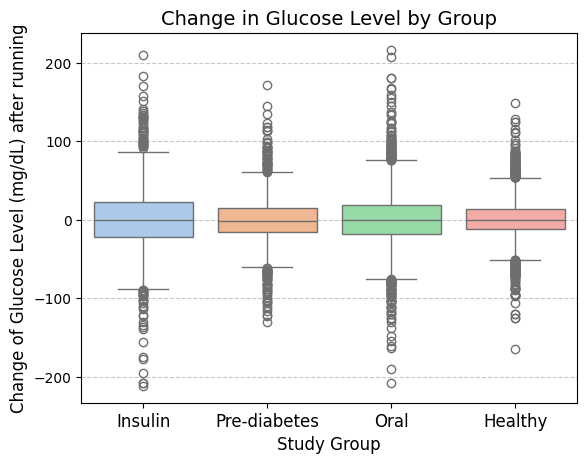

In [236]:
# Create a scatterplot for the delta of glucose levels
# Select the dynamic group column (can change 'study_group' to 'study_group_pre')
group_column = 'study_group_pre'  # Or 'study_group_pre'

readable_names = {
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'insulin_dependent': 'Insulin',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Oral',
    # Add other mappings as needed
}

# Replace original values with readable ones
data_with_qualified_running_all[group_column] = data_with_qualified_running_all[group_column].replace(readable_names)

# Basic boxplot without jitter or custom x-axis handling
sns.boxplot(x=group_column, y='delta', data=data_with_qualified_running_all, palette='pastel')

plt.title('Change in Glucose Level by Group', fontsize=14)
plt.xlabel('Study Group', fontsize=12)
plt.xticks(fontsize=12)  # Rotate x-ticks for better readability
plt.ylabel('Change of Glucose Level (mg/dL) after running', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Train data

C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\580275741.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_column, y='delta_exact', data=data_with_qualified_running_all, palette='pastel')


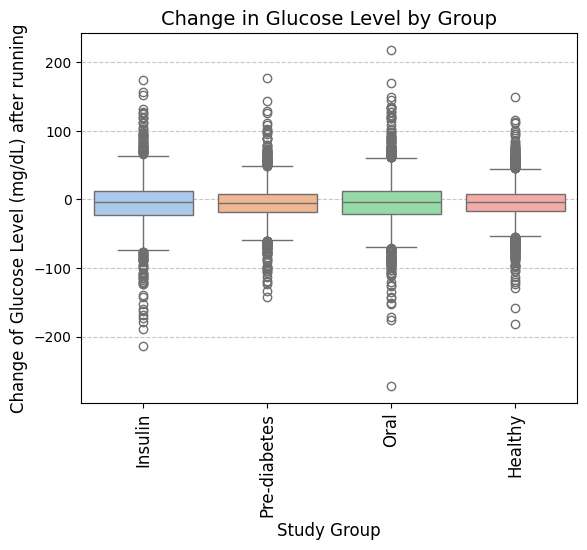

In [237]:
# Create a scatterplot for the delta of glucose levels
# Select the dynamic group column (can change 'study_group' to 'study_group_pre')
group_column = 'study_group_pre'  # Or 'study_group_pre'

# Map categorical values to numbers (0, 1, 2, ...)
unique_groups = data_with_qualified_running_all[group_column].unique()
group_mapping = {group: i for i, group in enumerate(unique_groups)}

# Basic boxplot without jitter or custom x-axis handling
sns.boxplot(x=group_column, y='delta_exact', data=data_with_qualified_running_all, palette='pastel')

plt.title('Change in Glucose Level by Group', fontsize=14)
plt.xlabel('Study Group', fontsize=12)
plt.xticks(rotation=90, fontsize=12)  # Rotate x-ticks for better readability
plt.ylabel('Change of Glucose Level (mg/dL) after running', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Population model


C:\Users\Hieu\AppData\Local\Temp\ipykernel_20048\1804964343.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['study_group_pre'] = X['study_group_pre'].astype('category').cat.codes


   age    BMI  study_group_pre  duration_minutes  glucose_before
0   67  32.76                1              36.0          111.33
1   67  32.76                1              33.0          134.50
2   67  32.76                1              64.0          199.33
3   67  32.76                1              45.0          117.50
4   67  32.76                1             111.0          125.17
age                 0
BMI                 0
study_group_pre     0
duration_minutes    0
glucose_before      0
dtype: int64
0
Train set shape: (7011, 5), Test set shape: (1753, 5)
k = 5: Cross-validation scores = [0.86138049 0.86993725 0.86765545 0.87849401 0.86986301]
Average CV Accuracy = 0.8695
k = 10: Cross-validation scores = [0.85974914 0.85860889 0.87913341 0.8631699  0.88356164 0.85844749
 0.87214612 0.87899543 0.88242009 0.87214612]
Average CV Accuracy = 0.8708
k = 15: Cross-validation scores = [0.86837607 0.84957265 0.85982906 0.88205128 0.87671233 0.84417808
 0.89726027 0.85616438 0.86472603 0

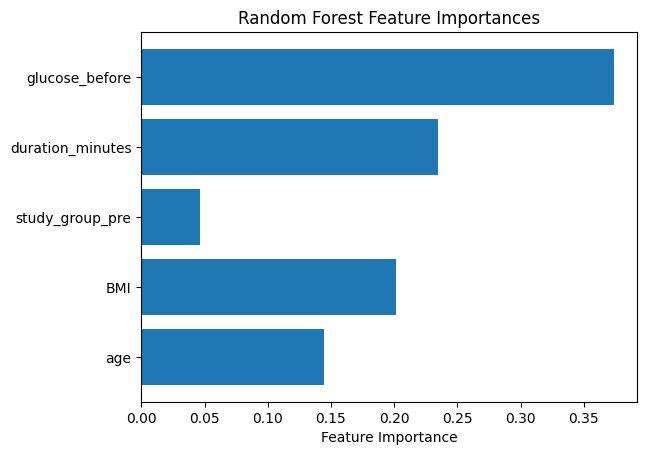

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Map study_group to numerical values
X = data_with_qualified_running_all[['age', 'BMI', 'study_group_pre', 'duration_minutes', 'glucose_before']]

# Map study_group_pre to numerical values manually
X['study_group_pre'] = X['study_group_pre'].astype('category').cat.codes

print(X.head())  # Check the first few rows of the DataFrame

# Split back into X and y
y = data_with_qualified_running_all['alarm']

print(X.isnull().sum())  # Check for any remaining missing values in features
print(y.isnull().sum())

# Reset index
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Split train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Define different k values
k_values = [5, 10, 15]
cv_accuracies = []

# Loop over each k
for k in k_values:
  cv = KFold(n_splits=k, shuffle=True, random_state=42)
  cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
  mean_score = np.mean(cv_scores)
  cv_accuracies.append(mean_score)
  print(f"k = {k}: Cross-validation scores = {cv_scores}")
  print(f"Average CV Accuracy = {mean_score:.4f}")

print(f"\n=== {k}-Fold Cross Validation ===")
print("Cross-validation scores:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))

import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

# Can add confusion matrix

# Individual model


In [ ]:
# Using the data that has been combined based on the ID
individial_data = pd.read_csv("participant_glucose_exercise_data_all.csv")


In [239]:
print('Done')

Done
